In [43]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
from pycaret.regression import *
import missingno as msno
import matplotlib.pyplot as plt

### Data

In [44]:
data_original = pd.read_csv('./sonar_training.csv', index_col=0)
data_original.drop(columns=['rok budowy'], inplace=True)
data_filled = pd.read_csv('./uzupelnienie127.csv', index_col=0)
data_filled.drop(columns=['Unnamed: 0'], inplace=True)
data_filled['cena'] = data_filled['cena'].str.replace(' zł', '')
data_filled['cena'] = data_filled['cena'].str.replace(' ', '').astype(float)
data_filled['cena'] = data_filled['cena'].replace(0, np.nan)
data_filled.head()

,cena,ulica,pokoje,powierzchnia,piętro,liczba pięter,stan wykonczenia,balkon/ogrod/taras,miejsce parkingowe,rok budowy
0,970151.0,Ślężna,4,91.94,1,7,Do odświeżenia,True,True,1969
1,821482.0,Konduktorska,5,97.54,1,1,Do odświeżenia,True,False,1969
2,655275.0,Ślężna,3,59.93,5,7,Do odświeżenia,True,True,1969
3,878386.0,Walecznych,4,84.86,2,5,Do odświeżenia,True,True,1969
4,479372.0,Ślężna,2,41.00,3,7,Do odświeżenia,True,True,1969


In [45]:
data_morizon = pd.read_csv('./morizon_train.csv')
data_morizon

,cena,ulica,pokoje,powierzchnia,piętro,liczba pięter,stan wykonczenia,balkon/ogrod/taras,miejsce parkingowe,rok budowy
0,0.0,Gajowa,3,54.71,1.0,3.0,Do remontu,False,False,2025
1,609000.0,Gnieźnieńska,1,38.37,4.0,4.0,Do remontu,True,False,2023
2,0.0,Gajowa,3,50.02,1.0,3.0,Do remontu,False,False,2025
3,0.0,Gajowa,3,54.89,1.0,3.0,Do remontu,False,False,2025
4,635000.0,Kossaka,2,53.06,3.0,5.0,Do remontu,True,False,1995
...,...,...,...,...,...,...,...,...,...,...
4752,819000.0,Wagnera,1,65.00,1.0,4.0,Do remontu,True,False,2011
4753,541551.0,Zielna,1,55.83,2.0,3.0,Do remontu,False,False,2023
4754,1349000.0,Zamkowa,1,96.93,9.0,9.0,Do remontu,True,False,2022
4755,574555.0,Gajowa,1,47.20,4.0,4.0,Do remontu,False,False,2024


In [46]:

data = pd.concat([data_original, data_filled], ignore_index = True)
data

,cena,ulica,pokoje,powierzchnia,piętro,liczba pięter,stan wykonczenia,balkon/ogrod/taras,miejsce parkingowe,rok budowy
0,906780.0,Zamkowa,5,88.90,1,1,Do odświeżenia,True,True,NaN
1,649000.0,Zamkowa,2,38.65,1,6,Do odświeżenia,True,False,NaN
2,824000.0,Nowowiejska,2,66.71,4,5,Gotowe do wprowadzenia,True,False,NaN
3,519800.0,Rudzka,2,35.00,5,10,Gotowe do wprowadzenia,False,True,NaN
4,639000.0,Brzeska,2,39.50,1,4,Gotowe do wprowadzenia,False,False,NaN
...,...,...,...,...,...,...,...,...,...,...
10360,NaN,gen. Władysława Sikorskiego,2,44.34,10,23,Do remontu,True,True,1969.0
10361,NaN,Grodzieńska,3,60.45,1,2,Do odświeżenia,True,True,1969.0
10362,NaN,Nyska,3,68.60,2,4,Do odświeżenia,True,True,1969.0
10363,NaN,gen. Władysława Sikorskiego,3,52.00,5,23,Do remontu,True,True,1969.0


In [47]:
data = data[data.cena < 1e7]
data['rok budowy'].fillna(1969, inplace = True)

model_data = data[~data.cena.isna()]
data.head()

,cena,ulica,pokoje,powierzchnia,piętro,liczba pięter,stan wykonczenia,balkon/ogrod/taras,miejsce parkingowe,rok budowy
0,906780.0,Zamkowa,5,88.90,1,1,Do odświeżenia,True,True,1969.0
1,649000.0,Zamkowa,2,38.65,1,6,Do odświeżenia,True,False,1969.0
2,824000.0,Nowowiejska,2,66.71,4,5,Gotowe do wprowadzenia,True,False,1969.0
3,519800.0,Rudzka,2,35.00,5,10,Gotowe do wprowadzenia,False,True,1969.0
4,639000.0,Brzeska,2,39.50,1,4,Gotowe do wprowadzenia,False,False,1969.0


In [48]:
model_data['stan wykonczenia'] = model_data['stan wykonczenia'].map({'Do remontu': 0, 'Do odświeżenia': 1, 'Gotowe do wprowadzenia': 2})
label_encoder = LabelEncoder()
model_data['ulica'] = label_encoder.fit_transform(model_data['ulica'])
model_data

,cena,ulica,pokoje,powierzchnia,piętro,liczba pięter,stan wykonczenia,balkon/ogrod/taras,miejsce parkingowe,rok budowy
0,906780.0,636,5,88.90,1,1,1,True,True,1969.0
1,649000.0,636,2,38.65,1,6,1,True,False,1969.0
2,824000.0,375,2,66.71,4,5,2,True,False,1969.0
3,519800.0,478,2,35.00,5,10,2,False,True,1969.0
4,639000.0,53,2,39.50,1,4,2,False,False,1969.0
...,...,...,...,...,...,...,...,...,...,...
9488,756851.0,661,2,44.71,10,23,0,True,True,1969.0
9489,526437.0,296,3,54.90,0,2,1,False,True,1969.0
9490,570901.0,125,3,54.47,3,3,1,False,True,1969.0
9491,552074.0,211,3,58.75,0,4,1,True,True,1969.0


### Pycaret

In [83]:
randomized_data = model_data.sample(frac=1, random_state=41)
randomized_data.reset_index(drop=True, inplace=True)
randomized_data

,cena,ulica,pokoje,powierzchnia,piętro,liczba pięter,stan wykonczenia,balkon/ogrod/taras,miejsce parkingowe,rok budowy
0,870000.0,260,4,98.00,1,4,1,False,False,1969.0
1,849998.0,636,3,70.20,2,2,2,True,True,1969.0
2,980299.0,652,3,90.01,1,7,1,True,True,1969.0
3,359000.0,643,1,25.55,2,3,2,False,False,1969.0
4,911752.0,475,3,78.96,4,6,1,True,True,1969.0
...,...,...,...,...,...,...,...,...,...,...
9485,631800.0,125,3,53.50,1,2,1,True,True,1969.0
9486,0.0,536,3,59.78,1,4,1,True,True,1969.0
9487,0.0,445,1,27.51,1,10,1,True,True,1969.0
9488,535374.0,125,3,54.63,2,4,1,True,True,1969.0


In [84]:
model_data0 = randomized_data[randomized_data.cena != 0]
train_size = int(0.75 * len(model_data0))
train_data = model_data0[:train_size]
test_data = model_data0[train_size:]

In [85]:
exp1 = setup(data=train_data, target='cena')
mod = create_model('xgboost', data = train_data, target = 'cena')
tuned_model = tune_model(mod)

,Description,Value
0,Session id,1433
1,Target,cena
2,Target type,Regression
3,Original data shape,"(6368, 10)"
4,Transformed data shape,"(6368, 10)"
5,Transformed train set shape,"(4457, 10)"
6,Transformed test set shape,"(1911, 10)"
7,Numeric features,7
8,Preprocess,True
9,Imputation type,simple


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,120032.7891,181835481088.0000,426421.7188,0.1120,0.1812,0.1187
1,95355.3906,30853439488.0000,175651.4688,0.5660,0.1709,0.1200
2,104924.1641,71976427520.0000,268284.2188,0.7306,0.1736,0.1162
3,121961.6172,196166418432.0000,442906.7812,0.4173,0.2042,0.1213
4,85532.5547,35607224320.0000,188698.7656,0.6096,0.1548,0.1026
5,79051.6953,21696894976.0000,147298.6562,0.7312,0.1561,0.1031
6,95609.7422,33464184832.0000,182932.1875,0.7903,0.1681,0.1117
7,89686.6406,29779345408.0000,172566.9375,0.6439,0.1640,0.1085
8,106107.7188,102791766016.0000,320611.5625,-0.2533,0.2069,0.1348


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,113264.4844,87941652480.0000,296549.5938,0.5705,0.1710,0.1184
1,99917.0391,27276222464.0000,165155.1406,0.6164,0.1777,0.1291
2,118965.3516,109490741248.0000,330893.8438,0.5901,0.1860,0.1266
3,133345.9688,207811887104.0000,455863.9062,0.3827,0.2157,0.1373
4,94615.9922,36996775936.0000,192345.4531,0.5944,0.1651,0.1118
5,89013.1094,25180811264.0000,158684.6250,0.6881,0.1661,0.1147
6,111442.9609,46157160448.0000,214842.1719,0.7107,0.1833,0.1266
7,92824.7734,25841285120.0000,160752.2500,0.6910,0.1636,0.1144
8,100007.1562,31118604288.0000,176404.6562,0.6206,0.1879,0.1310


Fitting 10 folds for each of 10 candidates, totalling 100 fits


In [86]:
tuned_model.get_params

<bound method XGBModel.get_params of XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.9,
             data=          cena  ulica  pokoje  powierzchnia  piętro  liczba pięter  \
0     870000.0    260       4         98.00       1              4   
1     849998.0    636       3         70.20       2              2   
2     980299.0    652       3         90.01       1              7   
3     359000.0    643       1         25.55       2              3   
4     911752.0    475       3         78.96       4              6   
...        ...    ...     ...           ...     ...            ...   
7100  508970.0    643       2         46.27       3              3   
7101  631000.0    682       3         63.11       0              0   
7102  5...
             eval_metric=None, feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,

In [87]:

final_model = predict_model(tuned_model, data=test_data)
sample_results = final_model[['cena', 'prediction_label']]#.sample(10)
y_test = final_model['cena']
predictions = final_model['prediction_label']

sample_results

,cena,prediction_label
7106,729975.0,6.842366e+05
7107,905000.0,7.241185e+05
7108,1800000.0,2.089345e+06
7109,1280000.0,1.235167e+06
7110,639000.0,6.293624e+05
...,...,...
9482,859005.0,8.822109e+05
9484,696000.0,7.215884e+05
9485,631800.0,6.033122e+05
9488,535374.0,6.833662e+05


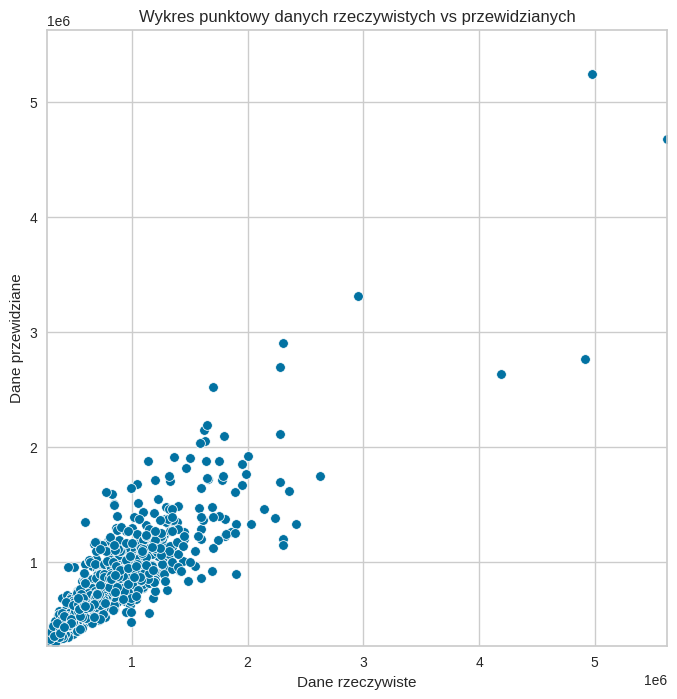

In [88]:
min_value = min(y_test.min(), predictions.min())
max_value = max(y_test.max(), predictions.max())

plt.figure(figsize=(8, 8))
sns.scatterplot(x=y_test, y=predictions)
plt.xlabel('Dane rzeczywiste')
plt.ylabel('Dane przewidziane')

# Set the same limits for both axes
plt.xlim(min_value, max_value)
plt.ylim(min_value, max_value)

plt.title('Wykres punktowy danych rzeczywistych vs przewidzianych')
plt.show()

In [99]:
r2_score(y_test, predictions)

0.7622753618853375

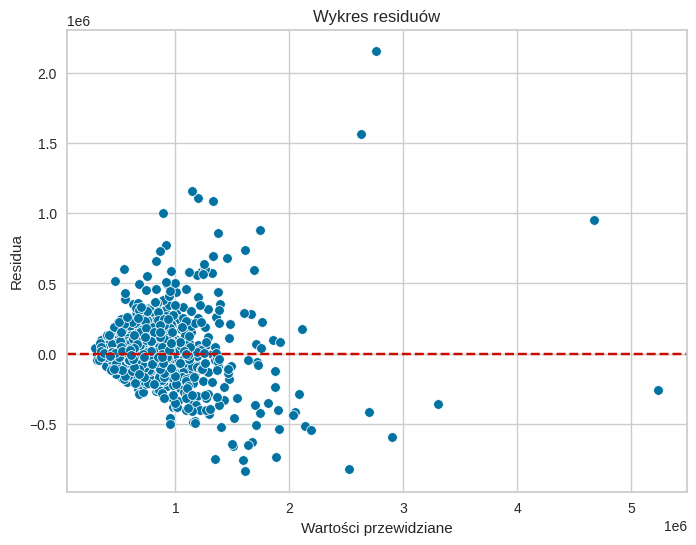

In [89]:
residuals = y_test - predictions

plt.figure(figsize=(8, 6))
sns.scatterplot(x=predictions, y=residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Wartości przewidziane')
plt.ylabel('Residua')
plt.title('Wykres residuów')
plt.show()


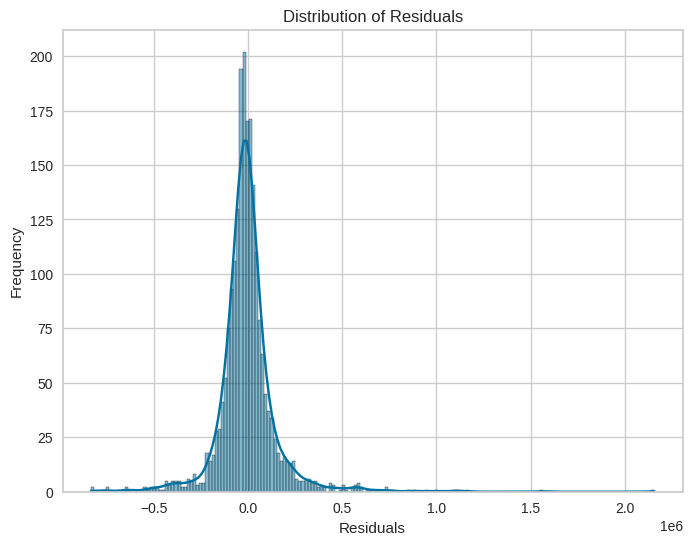

In [90]:
plt.figure(figsize=(8, 6))
sns.histplot(residuals, kde=True)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals')
plt.show()


In [92]:
sample_results['ER'].sort_values()

7778    -833239.875
7144    -821686.000
7354    -759505.250
8073    -748826.750
8857    -739042.000
           ...     
8043    1089056.000
7427    1106240.625
9341    1155106.250
8932    1560400.000
7511    2156830.000
Name: ER, Length: 2123, dtype: float32

In [93]:
y_test, y_mod = sample_results['cena'], sample_results['prediction_label']
r2 = r2_score(y_test, y_mod)
mse = mean_squared_error(y_test, y_mod)
print(f'Mean Squared Error: {mse/1e9} mld')
print(f'R-squared: {r2}')

Mean Squared Error: 26.88176128 mld
R-squared: 0.7622753618853375


In [94]:
modelled = predict_model(tuned_model, data=model_data[(model_data['cena'] == 0) | (model_data['cena'].isna())])
modelled['prediction_label'] = modelled['prediction_label'].round()
modelled

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extreme Gradient Boosting,754531.1250,650304421888.0000,806414.5625,0.0000,13.4896,nan


,ulica,pokoje,powierzchnia,piętro,liczba pięter,stan wykonczenia,balkon/ogrod/taras,miejsce parkingowe,rok budowy,cena,prediction_label
82,682,4,91.940002,1,7,1,True,True,1969.0,0.0,934676.0
118,256,5,97.540001,1,1,1,True,False,1969.0,0.0,942674.0
126,682,3,59.930000,5,7,1,True,True,1969.0,0.0,708515.0
139,586,4,84.860001,2,5,1,True,True,1969.0,0.0,1073330.0
151,682,2,41.000000,3,7,1,True,True,1969.0,0.0,578931.0
...,...,...,...,...,...,...,...,...,...,...,...
9355,661,2,44.340000,10,23,0,True,True,1969.0,0.0,976442.0
9356,150,3,60.450001,1,2,1,True,True,1969.0,0.0,638544.0
9358,377,3,68.599998,2,4,1,True,True,1969.0,0.0,788818.0
9359,661,3,52.000000,5,23,0,True,True,1969.0,0.0,979648.0


In [95]:
modelled.drop(columns=['cena'], inplace = True)
modelled.rename(columns={'prediction_label': 'cena'}, inplace = True)
modelled

,ulica,pokoje,powierzchnia,piętro,liczba pięter,stan wykonczenia,balkon/ogrod/taras,miejsce parkingowe,rok budowy,cena
82,682,4,91.940002,1,7,1,True,True,1969.0,934676.0
118,256,5,97.540001,1,1,1,True,False,1969.0,942674.0
126,682,3,59.930000,5,7,1,True,True,1969.0,708515.0
139,586,4,84.860001,2,5,1,True,True,1969.0,1073330.0
151,682,2,41.000000,3,7,1,True,True,1969.0,578931.0
...,...,...,...,...,...,...,...,...,...,...
9355,661,2,44.340000,10,23,0,True,True,1969.0,976442.0
9356,150,3,60.450001,1,2,1,True,True,1969.0,638544.0
9358,377,3,68.599998,2,4,1,True,True,1969.0,788818.0
9359,661,3,52.000000,5,23,0,True,True,1969.0,979648.0


In [96]:
modelled['ulica'] = label_encoder.inverse_transform(modelled['ulica'])
modelled['stan wykonczenia'] = model_data['stan wykonczenia'].map({0: 'Do remontu', 1: 'Do odświeżenia', 2: 'Gotowe do wprowadzenia'})
modelled.insert(0, 'cena', modelled.pop('cena'))
modelled

,cena,ulica,pokoje,powierzchnia,piętro,liczba pięter,stan wykonczenia,balkon/ogrod/taras,miejsce parkingowe,rok budowy
82,934676.0,Ślężna,4,91.940002,1,7,Do odświeżenia,True,True,1969.0
118,942674.0,Konduktorska,5,97.540001,1,1,Do odświeżenia,True,False,1969.0
126,708515.0,Ślężna,3,59.930000,5,7,Do odświeżenia,True,True,1969.0
139,1073330.0,Walecznych,4,84.860001,2,5,Do odświeżenia,True,True,1969.0
151,578931.0,Ślężna,2,41.000000,3,7,Do odświeżenia,True,True,1969.0
...,...,...,...,...,...,...,...,...,...,...
9355,976442.0,gen. Władysława Sikorskiego,2,44.340000,10,23,Do remontu,True,True,1969.0
9356,638544.0,Grodzieńska,3,60.450001,1,2,Do odświeżenia,True,True,1969.0
9358,788818.0,Nyska,3,68.599998,2,4,Do odświeżenia,True,True,1969.0
9359,979648.0,gen. Władysława Sikorskiego,3,52.000000,5,23,Do remontu,True,True,1969.0


In [97]:
data = data[data.cena != 0]
filled = pd.concat([data, modelled], ignore_index =True)
filled.sort_values('cena', ascending = False)
filled.to_csv('./filled_data.csv')

In [98]:
from pycaret.regression import save_model
save_model(tuned_model, 'model0')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(include=['ulica', 'pokoje', 'powierzchnia',
                                              'piętro', 'liczba pięter',
                                              'stan wykonczenia', 'rok budowy'],
                                     transformer=SimpleImputer())),
                 ('categorical_imputer',
                  TransformerWrapper(include=[],
                                     transformer=SimpleImputer(strategy='most_frequent'))),
                 ('clean_column_names',
                  Transforme...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.3,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
     